# Import necessary libraries

In [1]:
import torch
import os
import wget
import json
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetRegressor
from pathlib import Path

np.random.seed(0)
sb.set() 
model = TabNetRegressor(device_name='cuda') 


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [2]:
csv_data = pd.read_csv('data/clean_data/final_data.csv')

with open('data/clean_data/encoding_mappings.json', 'r') as fp:
    encoding_mappings = json.load(fp)

final_data_after2015 = csv_data[csv_data['Year'] >= 2015]
final_data_after2000 = csv_data[csv_data['Year'] >= 2000]


In [3]:
def encode_new_input(new_input, encoding_mappings):
# If new_input is a dictionary, convert it to a DataFrame
    if isinstance(new_input, dict):
        new_input = pd.DataFrame([new_input])
    
    # If new_input is a list of dictionaries, convert it to a DataFrame
    elif isinstance(new_input, list):
        new_input = pd.DataFrame(new_input)

    # Ensure that new_input is a DataFrame at this point
    if not isinstance(new_input, pd.DataFrame):
        raise ValueError("new_input must be a pandas DataFrame, a dictionary, or a list of dictionaries.")    
    new_input_encoded = new_input.copy()
    for column, mapping in encoding_mappings.items():
        if column in new_input.columns:
            # Apply the mapping to the column
            new_input_encoded[column] = new_input[column].map(mapping)
            # Fill in NaN values if the category was not seen during training
            if new_input_encoded[column].isna().any():
                unknown_rank = np.median(list(mapping.values()))
                # Use direct assignment instead of inplace=True
                new_input_encoded[column] = new_input_encoded[column].fillna(unknown_rank)
    
    return new_input_encoded

In [5]:
features = ['Year','floor_area_sqm', 'lease_commence_date', 'average_storey','town', 'flat_type', 'flat_model']
target = 'resale_price_adjusted'

# Employing basic linearing regression model with the numerical data

In [69]:
X_train_2015, X_test_2015, y_train_2015, y_test_2015 = train_test_split(final_data_after2015[features], final_data_after2015[target], test_size=0.1, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

xgbreg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree', 
    reg_alpha=0.1, 
    reg_lambda=0.1)
xgbreg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

X_train_tabnet, X_valid_tabnet, y_train_tabnet_log, y_valid_tabnet_log = train_test_split(X_train, y_train_log, 
                                                                                          test_size=0.1, 
                                                                                          random_state=42)

X_train_tabnet_values = X_train_tabnet.values
X_valid_tabnet_values = X_valid_tabnet.values
y_train_tabnet_log_values = y_train_tabnet_log.values.reshape(-1, 1)
y_valid_tabnet_log_values = y_valid_tabnet_log.values.reshape(-1, 1)

# Train a linear regression model after transformation
linreg_withLog = LinearRegression()
linreg_withLog.fit(X_train, y_train_log)

# Train a XGBoost model after transformation
xgbreg_withLog = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster='gbtree', 
    reg_alpha=0.1, 
    reg_lambda=0.1)
xgbreg_withLog.fit(X_train,y_train_log)

# Train a tabnet model after transformation
tabnetReg = TabNetRegressor()
max_epochs = 200

tabnetReg.fit(
    X_train_tabnet_values, 
    y_train_tabnet_log_values,
    eval_set=[(X_train_tabnet_values, y_train_tabnet_log_values), 
              (X_valid_tabnet_values, y_valid_tabnet_log_values)],
    eval_name=['train', 'valid'],
    eval_metric=['mae','rmse'],
    max_epochs = 200,
    patience = 20,
    batch_size = 4096,
    virtual_batch_size = 512,
    num_workers = 0,
    drop_last=False
)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 41.49165| train_mae: 2.66863 | train_rmse: 5.02736 | valid_mae: 2.72036 | valid_rmse: 5.18039 |  0:00:12s
epoch 1  | loss: 0.18235 | train_mae: 27.15066| train_rmse: 58.6235 | valid_mae: 27.49876| valid_rmse: 58.97975|  0:00:27s
epoch 2  | loss: 0.09018 | train_mae: 9.72652 | train_rmse: 25.61077| valid_mae: 10.07574| valid_rmse: 26.15349|  0:00:46s
epoch 3  | loss: 0.0701  | train_mae: 13.23043| train_rmse: 20.19676| valid_mae: 13.30878| valid_rmse: 20.35391|  0:01:04s
epoch 4  | loss: 0.06862 | train_mae: 4.92375 | train_rmse: 9.11324 | valid_mae: 4.95238 | valid_rmse: 9.18112 |  0:01:20s
epoch 5  | loss: 0.0562  | train_mae: 4.62166 | train_rmse: 8.34505 | valid_mae: 4.61522 | valid_rmse: 8.33844 |  0:01:38s
epoch 6  | loss: 0.04365 | train_mae: 2.33868 | train_rmse: 3.89208 | valid_mae: 2.3459  | valid_rmse: 3.93029 |  0:01:56s
epoch 7  | loss: 0.03681 | train_mae: 1.50909 | train_rmse: 2.43276 | valid_mae: 1.521   | valid_rmse: 2.48684 |  0:02:12s
epoch 8  | loss:

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


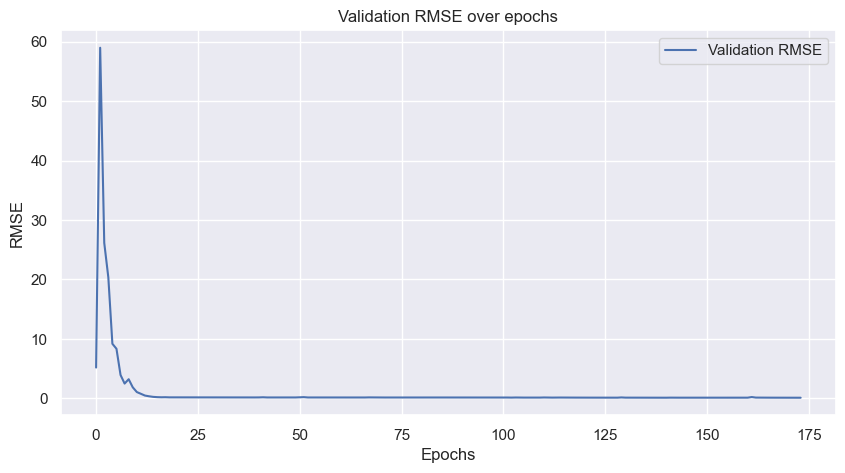

In [84]:
valid_rmse = tabnetReg.history['valid_rmse']

epochs = range(len(valid_rmse))

plt.figure(figsize=(10,5))
plt.plot(epochs, valid_rmse, label='Validation RMSE')
plt.title('Validation RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Goodness of Fit on Test Dataset:

Linear Regression Model:
Explained Variance (R^2): 0.6392660745932421
Mean Squared Error (MSE): 11770503332.413427

XGBoost Model:
Explained Variance (R^2): 0.9534746026449086
Mean Squared Error (MSE): 1518092161.6741936

Linear Regression Model (with log transformation):
Explained Variance (R^2): 0.6933784553549676
Mean Squared Error (MSE): 0.03328611122690218

XGBoost Model (with log transformation):
Explained Variance (R^2): 0.9529392848250695
Mean Squared Error (MSE): 0.005108800171050458

Tabnet Model (with log transformation):
Explained Variance (R^2): 0.9046488343321718
Mean Squared Error (MSE): 0.010351097505912078



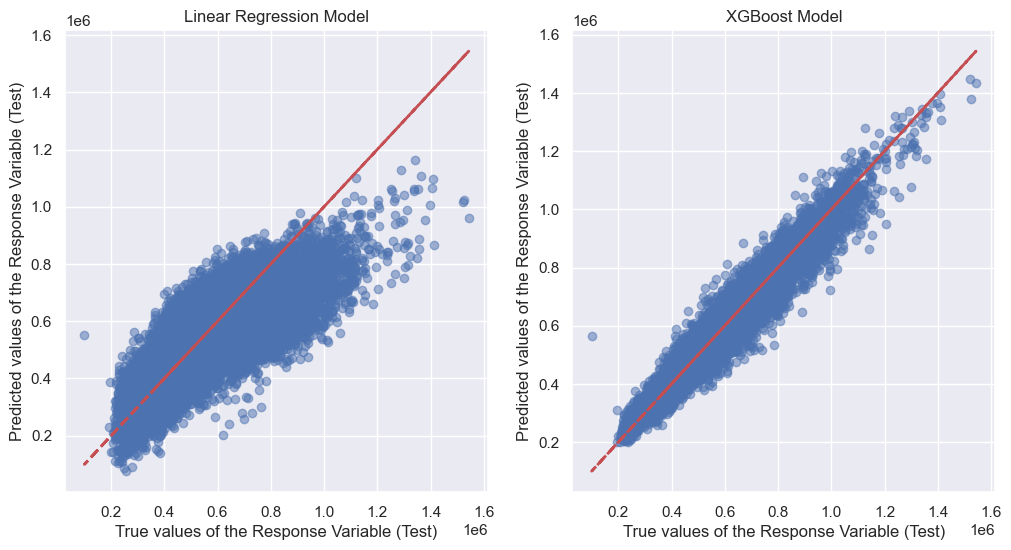

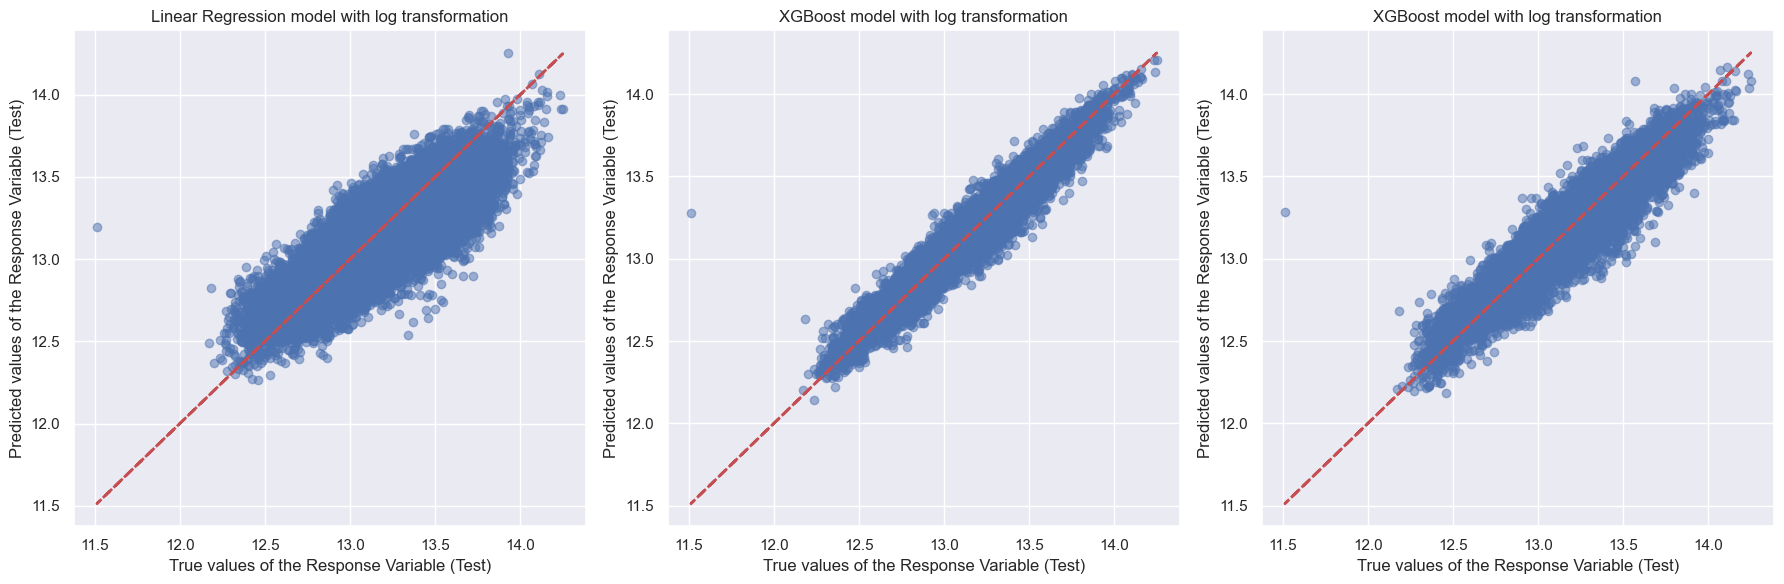

In [71]:
y_test_pred_linReg = linreg.predict(X_test)
y_test_pred_xgb = xgbreg.predict(X_test)
y_test_pred_linReg_log = linreg_withLog.predict(X_test)
y_test_pred_xgb_log =  xgbreg_withLog.predict(X_test)
y_test_pred_tabnet_log = tabnetReg.predict(X_test.values)

print("Goodness of Fit on Test Dataset:")
print()
print("Linear Regression Model:")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_linReg))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_linReg))
print()

print("XGBoost Model:")
print("Explained Variance (R^2):", r2_score(y_test, y_test_pred_xgb))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_xgb))
print()

print("Linear Regression Model (with log transformation):")
print("Explained Variance (R^2):", r2_score(y_test_log, y_test_pred_linReg_log))
print("Mean Squared Error (MSE):", mean_squared_error(y_test_log, y_test_pred_linReg_log))
print()

print("XGBoost Model (with log transformation):")
print("Explained Variance (R^2):", r2_score(y_test_log, y_test_pred_xgb_log))
print("Mean Squared Error (MSE):", mean_squared_error(y_test_log, y_test_pred_xgb_log))
print()


print("Tabnet Model (with log transformation):")
print("Explained Variance (R^2):", r2_score(y_test_log, y_test_pred_tabnet_log))
print("Mean Squared Error (MSE):", mean_squared_error(y_test_log, y_test_pred_tabnet_log))
print()

# Plot the Predictions versus True values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_linReg, alpha= 0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Linear Regression Model")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_xgb, alpha= 0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("XGBoost Model")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(y_test_log, y_test_pred_linReg_log, alpha=0.5)
plt.plot(y_test_log, y_test_log, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Linear Regression model with log transformation")

plt.subplot(1, 3, 2)
plt.scatter(y_test_log, y_test_pred_xgb_log, alpha=0.5)
plt.plot(y_test_log, y_test_log, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("XGBoost model with log transformation")

plt.subplot(1, 3, 3)
plt.scatter(y_test_log, y_test_pred_tabnet_log, alpha=0.5)
plt.plot(y_test_log, y_test_log, 'r--', linewidth=2)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("XGBoost model with log transformation")
plt.tight_layout()
plt.show()

In [82]:
linear_regression_coefficients = linreg_withLog.coef_
linear_regression_intercept = linreg_withLog.intercept_
linear_regression_withLog_coefficients = linreg_withLog.coef_
linear_regression_withLog_intercept = linreg_withLog.intercept_


xgboost_feature_importances = xgbreg.feature_importances_
xgboost_withLog_feature_importances = xgbreg_withLog.feature_importances_

tabnet_feature_importances = tabnetReg.feature_importances_


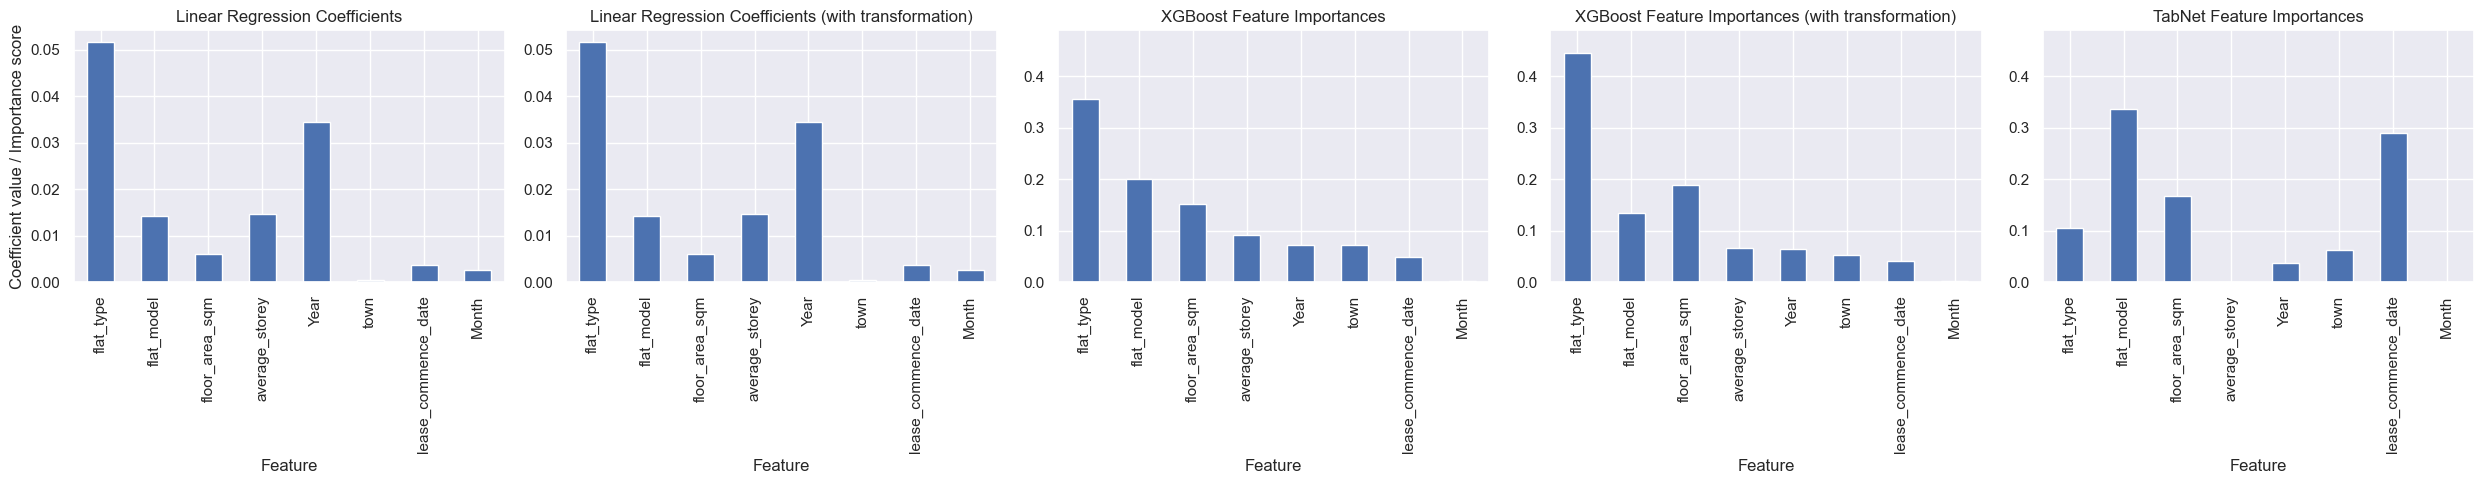

In [83]:
# Create a DataFrame to hold the feature importances
df_feature_importance = pd.DataFrame({
    'Feature': features,
    'Linear Regression': linear_regression_coefficients,
    'Linear Regression (with transformation)': linear_regression_withLog_coefficients,
    'XGBoost': xgboost_feature_importances,
    'XGBoost (with transformation)': xgboost_withLog_feature_importances,
    'TabNet': tabnet_feature_importances
})

df_feature_importance.sort_values(by='XGBoost', ascending=False, inplace=True)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
df_feature_importance.plot(kind='bar', x='Feature', y='Linear Regression', ax=axes[0], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='Linear Regression (with transformation)', ax=axes[1], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='XGBoost', ax=axes[2], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='XGBoost (with transformation)', ax=axes[3], legend=False)
df_feature_importance.plot(kind='bar', x='Feature', y='TabNet', ax=axes[4], legend=False)

axes[0].set_title('Linear Regression Coefficients')
axes[1].set_title('Linear Regression Coefficients (with transformation)')
axes[2].set_title('XGBoost Feature Importances')
axes[3].set_title('XGBoost Feature Importances (with transformation)')
axes[4].set_title('TabNet Feature Importances')

axes[0].set_ylabel('Coefficient value / Importance score')

# Find the global maximum importance for XGBoost and TabNet
xgb_max = max(max(xgboost_feature_importances), max(xgboost_withLog_feature_importances))
tabnet_max = max(tabnet_feature_importances)
common_max = max(xgb_max, tabnet_max)

# Set the same y-axis limits for the XGBoost and TabNet plots
for ax in axes[2:]:
    ax.set_ylim(0, common_max + 0.1 * common_max)

plt.tight_layout()
plt.show()

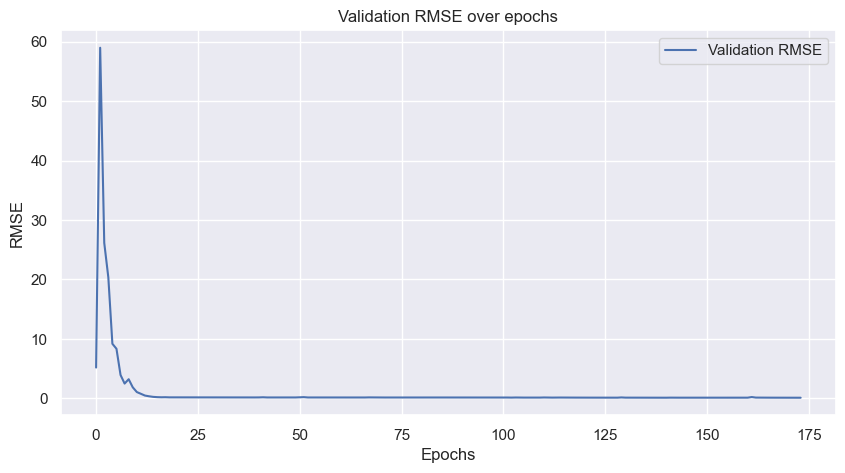

In [85]:
for category, mappings in encoding_mappings.items():
    print(f"{category}:")
    for key, value in mappings.items():
        print(f"  {key}: {value}")
    print() 


town:
  GEYLANG: 0
  ANG MO KIO: 1
  YISHUN: 2
  BEDOK: 3
  TOA PAYOH: 4
  BUKIT BATOK: 5
  QUEENSTOWN: 6
  CLEMENTI: 7
  JURONG EAST: 8
  JURONG WEST: 9
  WOODLANDS: 10
  KALLANG/WHAMPOA: 11
  HOUGANG: 12
  BUKIT PANJANG: 13
  SERANGOON: 14
  CHOA CHU KANG: 15
  SEMBAWANG: 16
  CENTRAL AREA: 17
  TAMPINES: 18
  MARINE PARADE: 19
  BUKIT MERAH: 20
  SENGKANG: 21
  PASIR RIS: 22
  PUNGGOL: 23
  BISHAN: 24
  BUKIT TIMAH: 25

flat_type:
  1 ROOM: 0
  2 ROOM: 1
  3 ROOM: 2
  4 ROOM: 3
  5 ROOM: 4
  EXECUTIVE: 5
  MULTI-GENERATION: 6

flat_model:
  Standard: 0
  2-room: 1
  Simplified: 2
  New Generation: 3
  Model A2: 4
  Model A: 5
  Improved: 6
  Premium Apartment: 7
  Adjoined flat: 8
  Apartment: 9
  Model A-Maisonette: 10
  Improved-Maisonette: 11
  Maisonette: 12
  Multi Generation: 13
  3Gen: 14
  Terrace: 15
  Premium Maisonette: 16
  DBSS: 17
  Type S1: 18
  Premium Apartment Loft: 19
  Type S2: 20



In [88]:
new_sample = {
    'Year': 2030, #'Year' and 'Month' represent when the user wants to sell the hdb
    'Month': 2,
    'floor_area_sqm': 143,
    'lease_commence_date': 2006,
    'average_storey': 10,
    'town': 'JURONG WEST',
    'flat_type': '5 ROOM',
    'flat_model': 'Premium Maisonette'
}

new_sample_df = pd.DataFrame([new_sample])

encoded_user_input = encode_new_input(new_sample_df, encoding_mappings)
encoded_user_input_array = encoded_user_input.to_numpy()

#annoying coz clf.predict take in array but linreg.predict take in df
predicted_resale_price_tabnet = np.exp(tabnetReg.predict(encoded_user_input_array))
predicted_resale_price_linreg = linreg.predict(encoded_user_input)
predicted_resale_price_linreg_withLog = np.exp(linreg_withLog.predict(encoded_user_input))
predicted_resale_price_xgb = xgbreg.predict(encoded_user_input)
predicted_resale_price_xgb_withLog = np.exp(xgbreg_withLog.predict(encoded_user_input))

print(f"Predicted Resale Value for Linear Regression:                       {predicted_resale_price_linreg[0]}")
print(f"Predicted Resale Value for Linear Regression with transformation:   {predicted_resale_price_linreg_withLog[0]}")
print(f"Predicted Resale Value for XGBoost:                                 {predicted_resale_price_xgb[0]}")
print(f"Predicted Resale Value for XGBoost with transformation:             {predicted_resale_price_xgb_withLog[0]}")
print(f"Predicted Resale Value for Tabnet:                                  {predicted_resale_price_tabnet[0]}")



Predicted Resale Value for Linear Regression:                       1019140.9423823431
Predicted Resale Value for Linear Regression with transformation:   1199536.709081289
Predicted Resale Value for XGBoost:                                 853195.5
Predicted Resale Value for XGBoost with transformation:             752397.625
Predicted Resale Value for Tabnet:                                  [914518.06]
